In [ ]:
import fastf1 as ff1
import pandas as pd
from fastf1.core import Laps
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
from timple.timedelta import strftimedelta
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm

fp = ff1.get_session(2023, 'Japan', 'FP2')
#fp_laps = fp.load_laps(with_telemetry=True)
fp.load()

In [16]:
drivers = pd.unique(fp.laps['Driver'])
driver_laps_static = fp.laps.pick_drivers(drivers)

In [ ]:
driver_laps = driver_laps_static.loc[((driver_laps_static['Driver'] == "VER")  & (driver_laps_static['IsAccurate']==True) & (driver_laps_static['Stint']==4)) |
                                     ((driver_laps_static['Driver'] == "LEC")  & (driver_laps_static['IsAccurate']==True) & (driver_laps_static['Stint']==4)) |
                                     ((driver_laps_static['Driver'] == "SAI")  & (driver_laps_static['IsAccurate']==True) & (driver_laps_static['Stint']==4)) |
                                     ((driver_laps_static['Driver'] == "HAM")  & (driver_laps_static['IsAccurate']==True) & ((driver_laps_static['Stint']==5)))|
                                     ((driver_laps_static['Driver'] == "RUS")  & (driver_laps_static['IsAccurate']==True) & (driver_laps_static['Stint']==4)) |
                                     ((driver_laps_static['Driver'] == "NOR")  & (driver_laps_static['IsAccurate']==True) & (driver_laps_static['Stint']==3))]
driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()


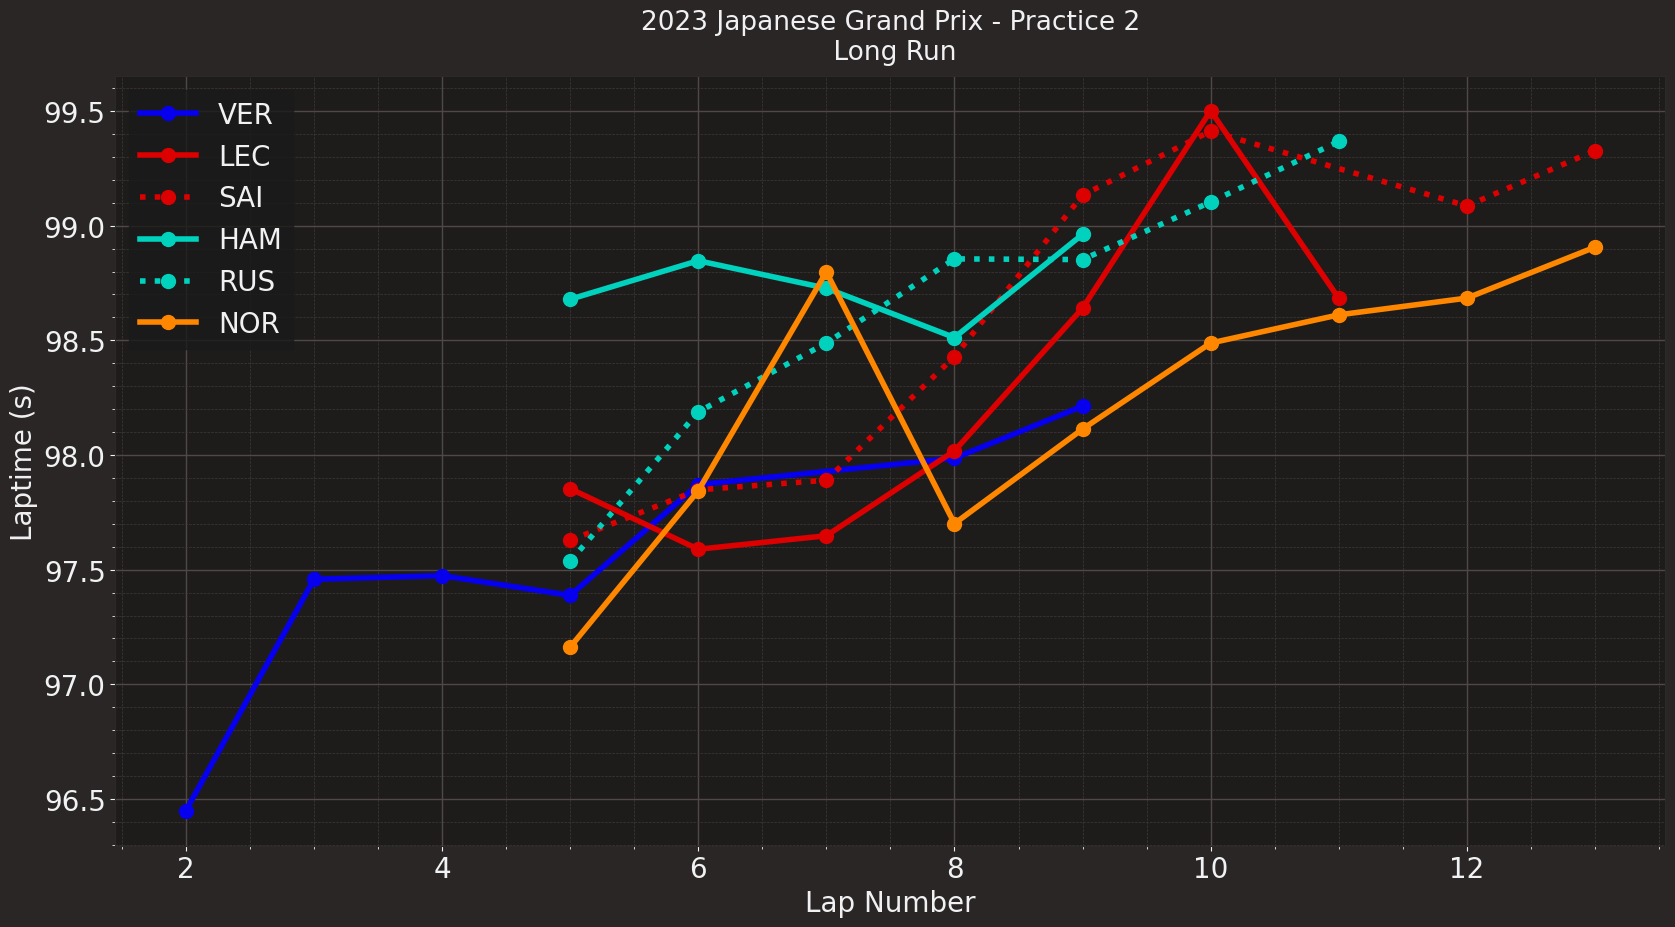

In [64]:

driver_laps = driver_laps.drop(driver_laps[driver_laps['LapTime(s)'] > 101].index)
drivers_to_visualize = ["VER", "LEC", "SAI", "HAM", "RUS", "NOR"]

# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [20, 10]
plotting.setup_mpl()
# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots()

# Lap-by-lap longrun comparison
for driver in drivers_to_visualize:
    single_driver_laps = driver_laps.pick_driver(driver)[['Driver', 'LapNumber', 'LapTime(s)', 'Team', 'TyreLife']]
  
    # Select all the laps from that driver
    single_driver_laps = single_driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(single_driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = single_driver_laps['TyreLife']
    
    # Y-coordinate a smoothed line between all the laptimes
    y = seconds=single_driver_laps['LapTime(s)']
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax.plot(x, y, label=driver, color=plotting.team_color(team), linestyle=linestyle, linewidth=4,  marker='o', markersize=10)
    
    # Append labels
    ax.set_ylabel("Laptime (s)", size=20)
    ax.set_xlabel("Lap Number", size=20)
    
    # Set title
    ax.set_title(f"{fp.event.year} {fp.event.EventName} - {fp.name}\n Long Run")

    # Generate legend
    ax.legend(prop={'size': 20})
    ax.tick_params(labelsize=20)
    visualized_teams.append(team)

In [ ]:
transformed_laps = driver_laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = driver_laps["LapTime"].dt.total_seconds()

# order the team from the fastest (lowest median lap time) tp slower
team_order = (
    transformed_laps[["Driver", "LapTime (s)"]]
    .groupby("Driver")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)
print(team_order)
# make a color palette associating drivers to hex codes
driver_palette =  dict()
for driver in team_order:
    driver_palette[driver] = "#"+fp.results[fp.results['Abbreviation'] == driver]['TeamColor'].values[0]

display(driver_palette)

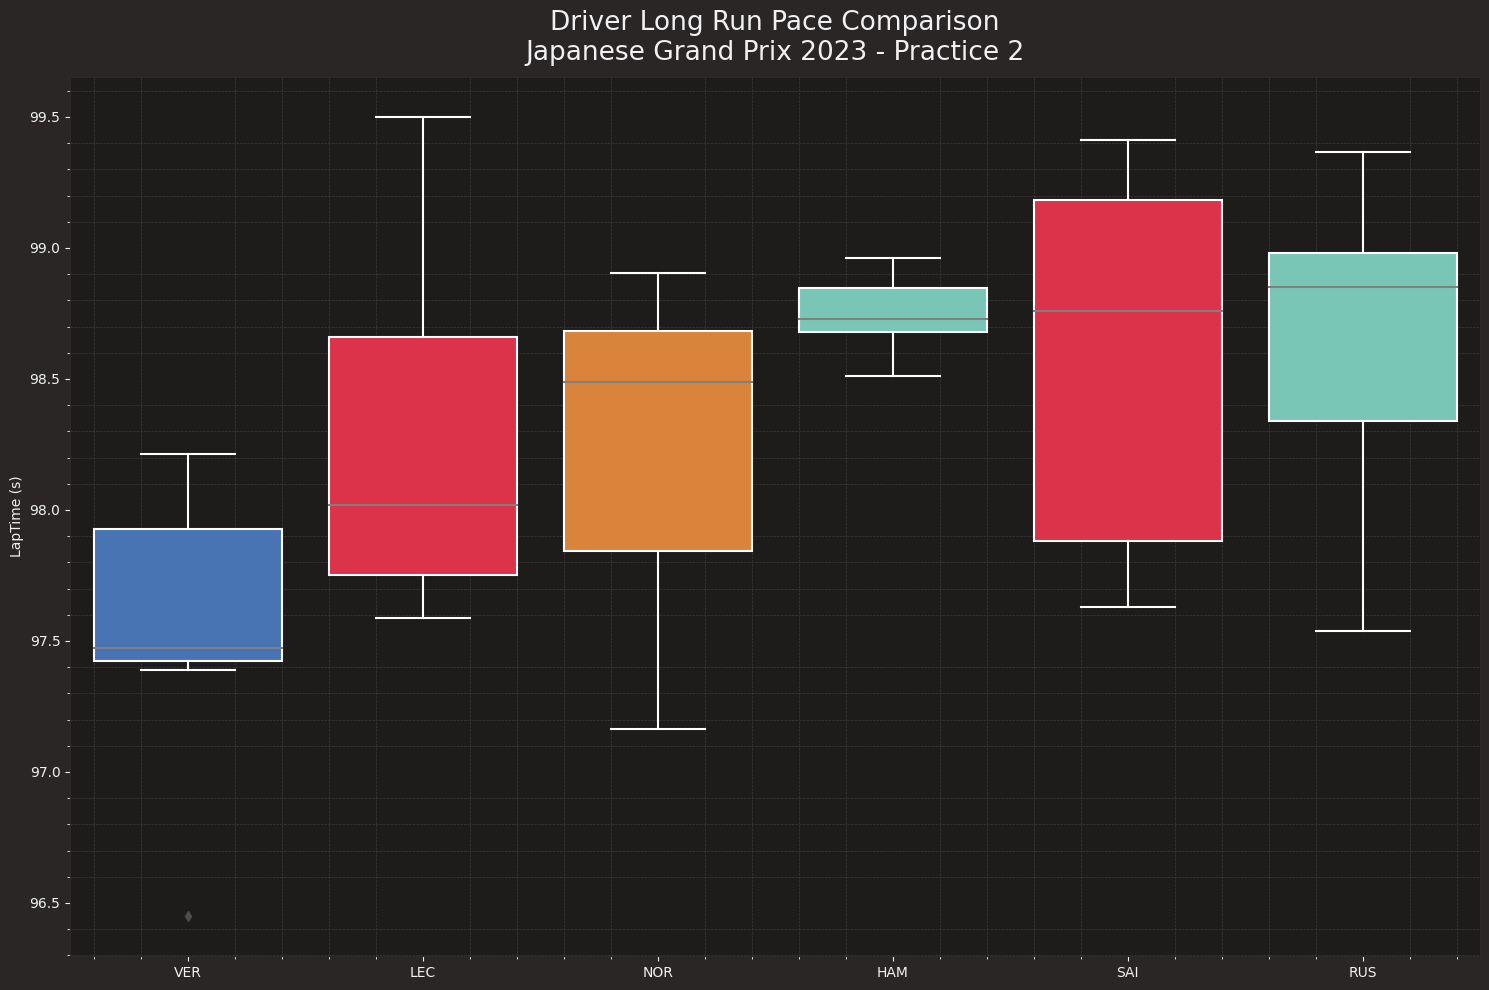

In [68]:

import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(
    data=transformed_laps,
    x="Driver",
    y="LapTime (s)",
    order=team_order,
    palette=driver_palette,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
)

plt.title(f"Driver Long Run Pace Comparison\n"
          f"{fp.event['EventName']} {fp.event.year} - {fp.name}")
plt.grid(visible=False)

ax.set(xlabel=None)
plt.tight_layout()
plt.show()